In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
import statsmodels.stats
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'cmr10'
matplotlib.rcParams['font.size'] = 8

In [3]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

NAMES = [
    'RU',
    'ST',
    'RO',
    'AD',
    'NO',
    'LA',]

tasks = {
    'binary': [0, 1], 
    'strat-binary': [0, 1],
    '4type': [0, 1, 2, 3],
    '5type': [0, 1, 2, 3, 4],
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['RandomUnder', 'SMOTETomek', 'RandomOver', 'ADASYN', 'none', 'aug']

In [4]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [5]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names, out=False, title=None, evaluation=None):
    dunn_values = dunn_values.to_numpy()
    lower = np.tril(dunn_values, k=-1)
    dunn_values = np.ma.array(dunn_values, mask=lower)
    
    names = [shorten_name(name) for name in names]
    names = NAMES if out else names
    
    cmap = matplotlib.colormaps['viridis']
    cmap.set_bad('w')
    
    plt.matshow(dunn_values, cmap=cmap)
    ax = plt.gca()
    
    #remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    #remove tick marks
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    rotation = 0 if out else 90
    ax.set_xticklabels(labels=names, rotation=rotation)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    for (i, j), z in np.ndenumerate(dunn_values):
        if out and j >= i:
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
        elif j >= i:
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
    if out:
        fig = ax.get_figure()
        fig.savefig(f'{title}-{evaluation}.pdf', bbox_inches='tight', pad_inches = 0)
        
    plt.pause(0.1)

In [6]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [7]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [8]:
#find which models performed best using different eval metrics
def evaluate_models(df, substrings, evaluation, answer):
    output_df = pd.DataFrame()
    combined_df = combine_columns(df, substrings)
    for column in substrings:
        temp_combined_df = combined_df.copy() if evaluation == 'recall' else combined_df[combined_df[column] == answer].copy()
        comparison_df = df if evaluation == 'recall' else df[df[column] == answer]
        temp_combined_df[column] = temp_combined_df[column] == comparison_df['Actual']
        output_df[column] = [None,] if len(temp_combined_df) == 0 else [sum(temp_combined_df[column])/len(temp_combined_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [9]:
def print_result(task, cochran_result, post_hoc_p, df, score_df):
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')

In [10]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications, evaluation):
    if evaluation == 'precision': return [df,] * len(classifications)
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

def get_mean(series):
    mean = np.mean(series)
    mean -= 1/len(series.dropna())
    mean /= len(series.dropna())
    mean *= len(series.dropna()-1)
    return mean

#find specific rankings for each model
def overall_evaluation(task, classifications, method, evaluation):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications, evaluation)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values, evaluation, i).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    indeces = list(score_df.index)
    score_df.loc[len(score_df)] = score_df.apply(get_mean, axis=0)
    indeces.append('Mean')
    score_df.index = indeces
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print_result(task, cochran_result, post_hoc_p, df, score_df)
    
    return score_df.drop(index=['Actual', 'Mean'])

In [11]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        indeces = list(score_df.index)
        score_df.loc[len(score_df)] = score_df.apply(get_mean, axis=0)
        indeces.append('Mean')
        score_df.index = indeces
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        '''
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')
        '''

In [12]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces, title, evaluation):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    #if 'Mean' not in indeces:
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Nemenyi test array:')
        visualize_dunn(p_values, list(overall_df.index), out=True, title=title, evaluation=evaluation)

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [13]:
def get_f1_df(precision_df, recall_df):
    return 2 * (precision_df * recall_df) / (precision_df + recall_df).replace(0, float('NaN'))

def evaluate_f1(task, method, score_df):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    cochran_result = cochrans_q(df)
    post_hoc_p = post_hoc_tests(df, df.columns.values)
    print_result(task, cochran_result, post_hoc_p, df, score_df)

def task_eval(task):
    print(f'\n\nTask: {task.title()}\n\n')
    evaluation_dict = dict()
    for evaluation in ['recall', 'precision']:
        evaluation_dict[evaluation] = []
        print(f'{evaluation.title()}\n')
        overall_df = pd.DataFrame()
        indeces = []
        for method in methods:
            print(f'\nMethod: {method}\n')
            temp_df = overall_evaluation(task, tasks[task], method, evaluation) #find the rankings for all models
            evaluation_dict[evaluation].append(temp_df)
            if not indeces:
                indeces = list(temp_df.index)
            overall_df[method] = temp_df['Mean score']
            #algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
        evaluate_resampling(overall_df, indeces, task, evaluation)
    
    print('\n\nTask: F1\n\n')
    f1_dfs = [get_f1_df(evaluation_dict['precision'][i], evaluation_dict['recall'][i]) for i in range(len(evaluation_dict['recall']))]
    f1_overall = pd.DataFrame()
    for (i, method) in enumerate(methods):
            indeces = list(f1_dfs[i].index)
            f1_dfs[i].loc[len(f1_dfs[i])] = [1.0,] * len(f1_dfs[i].columns.values)
            indeces.append('Actual')
            f1_dfs[i].loc[len(f1_dfs[i])] = f1_dfs[i].apply(get_mean, axis=0)
            indeces.append('Mean')
            f1_dfs[i].index = indeces
            
            evaluate_f1(task, method, f1_dfs[i])
            f1_dfs[i] = f1_dfs[i].drop(index=['Actual', 'Mean'])
            
            f1_overall[method] = f1_dfs[i]['Mean score']
            indeces = list(f1_dfs[i].index)
    evaluate_resampling(f1_overall, indeces, task, 'f1')



Task: Binary


Recall


Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 3.862783351798921e-260
Post-hoc Dunn test array:


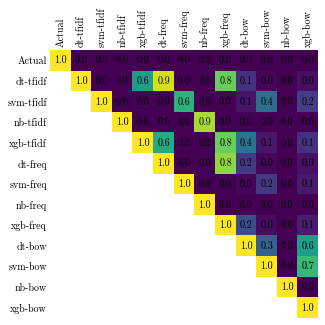

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.714612  0.662791    0.688701  0.536066
xgb-bow    0.706621  0.654070    0.680345  0.663115
svm-freq   0.800228  0.540698    0.670463  0.718033
dt-bow     0.704338  0.619186    0.661762  0.653279
svm-tfidf  0.809361  0.485465    0.647413  0.651639
xgb-freq   0.678082  0.604651    0.641367  0.680328
xgb-tfidf  0.694064  0.584302    0.639183  0.727049
dt-freq    0.680365  0.584302    0.632334  0.657377
dt-tfidf   0.690639  0.552326    0.621482  0.539344
nb-bow     0.575342  0.633721    0.604532  0.700000
nb-freq    0.471461  0.712209    0.591835  0.691803
nb-tfidf   0.476027  0.688953    0.582490  0.591803
Mean       0.615472  0.563283    0.589378  0.600757

Mean: 0.6608061087791893




Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


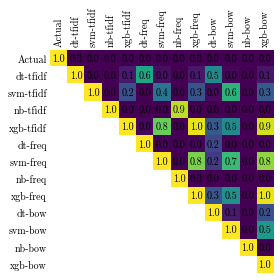

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.800228  0.534884    0.667556  0.711475
xgb-bow    0.773973  0.558140    0.666056  0.422131
svm-tfidf  0.824201  0.505814    0.665007  0.676230
svm-freq   0.796804  0.514535    0.655669  0.665574
dt-bow     0.748858  0.540698    0.644778  0.690164
xgb-freq   0.800228  0.488372    0.644300  0.424590
xgb-tfidf  0.802511  0.479651    0.641081  0.734426
dt-freq    0.764840  0.412791    0.588815  0.712295
dt-tfidf   0.791096  0.383721    0.587408  0.717213
nb-bow     0.455479  0.630814    0.543147  0.725410
nb-freq    0.277397  0.790698    0.534047  0.713115
nb-tfidf   0.283105  0.784884    0.533994  0.504918
Mean       0.624517  0.509615    0.567066  0.592119

Mean: 0.6384947814742334




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


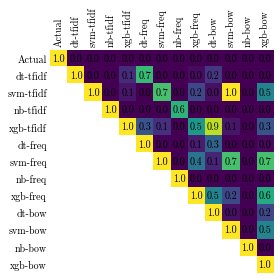

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.778539  0.601744    0.690141  0.691803
xgb-bow    0.770548  0.569767    0.670158  0.721311
svm-freq   0.804795  0.508721    0.656758  0.728689
svm-tfidf  0.821918  0.491279    0.656598  0.661475
dt-bow     0.752283  0.529070    0.640676  0.689344
xgb-freq   0.792237  0.479651    0.635944  0.431967
xgb-tfidf  0.772831  0.485465    0.629148  0.669672
nb-bow     0.538813  0.700581    0.619697  0.728689
dt-freq    0.763699  0.430233    0.596966  0.440984
dt-tfidf   0.755708  0.421512    0.588610  0.704098
nb-freq    0.302511  0.793605    0.548058  0.584426
nb-tfidf   0.293379  0.784884    0.539131  0.713934
Mean       0.626712  0.522809    0.574760  0.597415

Mean: 0.6461890291931706




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


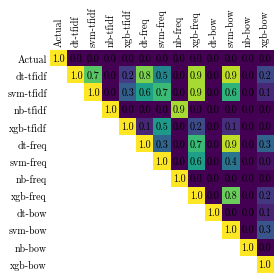

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.752283  0.569767    0.661025  0.681148
svm-tfidf  0.738584  0.575581    0.657083  0.700820
svm-bow    0.718037  0.595930    0.656983  0.413115
xgb-tfidf  0.803653  0.482558    0.643106  0.692623
xgb-bow    0.689498  0.590116    0.639807  0.689344
xgb-freq   0.761416  0.505814    0.633615  0.713115
dt-bow     0.650685  0.572674    0.611680  0.628689
dt-freq    0.785388  0.415698    0.600543  0.416393
dt-tfidf   0.804795  0.383721    0.594258  0.686066
nb-bow     0.444064  0.639535    0.541799  0.683607
nb-tfidf   0.272831  0.781977    0.527404  0.499180
nb-freq    0.265982  0.787791    0.526886  0.661475
Mean       0.591324  0.530859    0.561091  0.574275

Mean: 0.6325200099889491




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


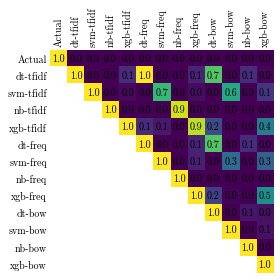

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.864155  0.421512    0.642833  0.694262
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
xgb-freq   0.863014  0.377907    0.620460  0.759016
xgb-tfidf  0.864155  0.366279    0.615217  0.723770
dt-bow     0.812785  0.415698    0.614242  0.700820
svm-freq   0.949772  0.273256    0.611514  0.694262
dt-tfidf   0.819635  0.375000    0.597317  0.726230
dt-freq    0.823059  0.366279    0.594669  0.472951
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.739344
Mean       0.713997  0.417263    0.565630  0.630328

Mean: 0.6370586512351405




Method: aug

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


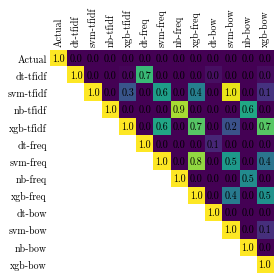

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.785388  0.572674    0.679031  0.645082
xgb-bow    0.727169  0.616279    0.671724  0.713115
svm-tfidf  0.812785  0.500000    0.656393  0.724590
xgb-freq   0.794521  0.491279    0.642900  0.459836
xgb-tfidf  0.787671  0.485465    0.636568  0.702459
svm-freq   0.821918  0.436047    0.628982  0.653279
dt-tfidf   0.716895  0.491279    0.604087  0.709016
dt-freq    0.723744  0.444767    0.584256  0.456557
dt-bow     0.651826  0.514535    0.583181  0.613115
nb-tfidf   0.309361  0.843023    0.576192  0.470492
nb-freq    0.304795  0.843023    0.573909  0.695902
nb-bow     0.345890  0.787791    0.566841  0.725410
Mean       0.598613  0.540474    0.569543  0.582219

Mean: 0.6409718891600065




Overall scores:
Friedman Chi Square Statistic: 13.095238095238074. p-value: 0.022502443866208633.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
svm-bow       0

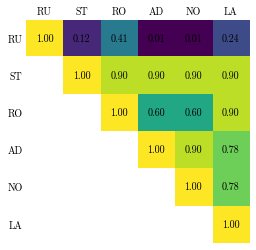

Precision


Method: RandomUnder

Task: binary.
Cochran's Q test p-value: 3.862783351798921e-260
Post-hoc Dunn test array:


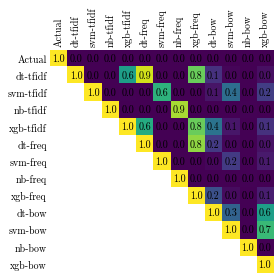

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.816065  0.515235    0.665650  0.663115
svm-bow    0.843666  0.476987    0.660327  0.651639
xgb-bow    0.838753  0.466805    0.652779  0.718033
svm-tfidf  0.800226  0.500000    0.650113  0.680328
dt-bow     0.824866  0.451271    0.638069  0.536066
xgb-freq   0.813699  0.424490    0.619094  0.653279
xgb-tfidf  0.809587  0.428571    0.619079  0.727049
dt-freq    0.806495  0.417879    0.612187  0.657377
dt-tfidf   0.797101  0.412148    0.604624  0.591803
nb-bow     0.800000  0.369492    0.584746  0.700000
nb-freq    0.806641  0.346045    0.576343  0.539344
nb-tfidf   0.795802  0.340517    0.568159  0.691803
Mean       0.750223  0.396111    0.573167  0.600757

Mean: 0.6445955824455734




Method: SMOTETomek

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


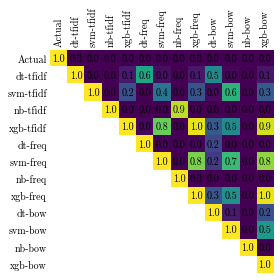

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.809417  0.530488    0.669952  0.424590
svm-bow    0.814170  0.512535    0.663352  0.734426
xgb-bow    0.816867  0.492308    0.654588  0.676230
svm-freq   0.806936  0.498592    0.652764  0.711475
xgb-freq   0.799316  0.489796    0.644556  0.717213
xgb-tfidf  0.797052  0.488166    0.642609  0.422131
dt-bow     0.805897  0.458128    0.632012  0.665574
dt-tfidf   0.765746  0.419048    0.592397  0.504918
dt-freq    0.768349  0.408046    0.588197  0.725410
nb-freq    0.771429  0.300552    0.535991  0.712295
nb-bow     0.758555  0.312680    0.535618  0.713115
nb-tfidf   0.770186  0.300668    0.535427  0.690164
Mean       0.729532  0.400847    0.565189  0.592119

Mean: 0.636618022137721




Method: RandomOver

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


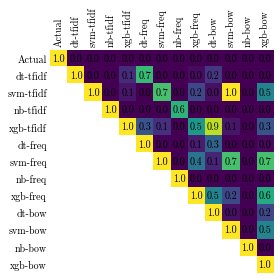

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.832723  0.516209    0.674466  0.661475
svm-tfidf  0.804469  0.520000    0.662235  0.669672
xgb-bow    0.820170  0.493703    0.656936  0.431967
svm-freq   0.806636  0.505780    0.656208  0.691803
xgb-freq   0.794960  0.475504    0.635232  0.440984
dt-bow     0.802680  0.456140    0.629410  0.721311
xgb-tfidf  0.792740  0.456284    0.624512  0.704098
nb-bow     0.820870  0.373643    0.597256  0.728689
dt-freq    0.773410  0.416901    0.595156  0.584426
dt-tfidf   0.768873  0.403900    0.586387  0.713934
nb-freq    0.788690  0.308824    0.548757  0.689344
nb-tfidf   0.776435  0.303712    0.540074  0.728689
Mean       0.737127  0.402354    0.569741  0.597415

Mean: 0.6411692793773993




Method: ADASYN

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


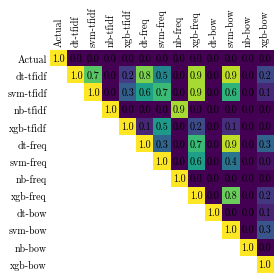

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.816605  0.474576    0.645590  0.692623
xgb-tfidf  0.798186  0.491124    0.644655  0.681148
svm-tfidf  0.815889  0.463700    0.639795  0.416393
svm-bow    0.819010  0.453540    0.636275  0.686066
xgb-freq   0.796894  0.454308    0.625601  0.700820
xgb-bow    0.810738  0.427368    0.619053  0.713115
dt-freq    0.773903  0.432024    0.602964  0.689344
dt-tfidf   0.768811  0.435644    0.602227  0.628689
dt-bow     0.794979  0.391650    0.593315  0.413115
nb-bow     0.758285  0.311174    0.534729  0.661475
nb-tfidf   0.761146  0.296909    0.529028  0.499180
nb-freq    0.761438  0.296499    0.528968  0.683607
Mean       0.728914  0.379117    0.554015  0.574275

Mean: 0.6254440336010783




Method: none

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


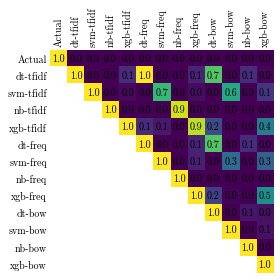

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.800199  0.668224    0.734212  0.767213
svm-tfidf  0.780303  0.682927    0.731615  0.759016
svm-freq   0.768946  0.681159    0.725053  0.664754
xgb-bow    0.791841  0.549242    0.670542  0.694262
xgb-freq   0.779381  0.520000    0.649691  0.726230
xgb-tfidf  0.776410  0.514286    0.645348  0.700820
dt-bow     0.779847  0.465798    0.622822  0.472951
nb-bow     0.804433  0.428256    0.616344  0.694262
dt-tfidf   0.769561  0.449477    0.609519  0.777049
dt-freq    0.767838  0.448399    0.608118  0.739344
nb-tfidf   0.794486  0.319123    0.556805  0.474590
nb-freq    0.793451  0.318348    0.555899  0.723770
Mean       0.723592  0.465018    0.594305  0.630328

Mean: 0.6657337827117813




Method: aug

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


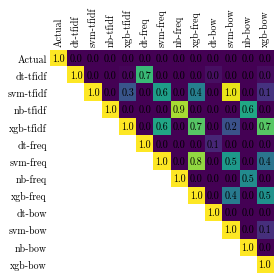

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.823952  0.511688    0.667820  0.702459
svm-tfidf  0.805430  0.511905    0.658667  0.713115
xgb-bow    0.828349  0.470067    0.649208  0.459836
xgb-freq   0.799082  0.484241    0.641661  0.456557
svm-freq   0.787746  0.490196    0.638971  0.613115
xgb-tfidf  0.795848  0.473088    0.634468  0.709016
dt-tfidf   0.782067  0.405276    0.593672  0.725410
nb-tfidf   0.833846  0.324022    0.578934  0.653279
dt-freq    0.768485  0.387342    0.577913  0.695902
nb-freq    0.831776  0.322581    0.577178  0.724590
dt-bow     0.773713  0.367220    0.570466  0.470492
nb-bow     0.805851  0.321090    0.563471  0.645082
Mean       0.741242  0.389901    0.565571  0.582219

Mean: 0.637000045982841




Overall scores:
Friedman Chi Square Statistic: 19.428571428571388. p-value: 0.0015989175220522934.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
svm-freq      0

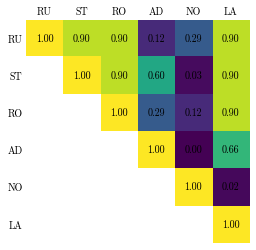



Task: F1


Task: binary.
Cochran's Q test p-value: 2.8099410340884067e-187
Post-hoc Dunn test array:


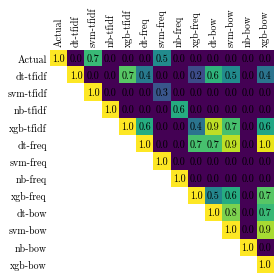

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.759852  0.522059    0.649699  0.588896
dt-freq    0.738080  0.487273    0.622098  0.657377
dt-tfidf   0.740061  0.472050    0.612938  0.564357
nb-bow     0.669323  0.466809    0.594474  0.700000
nb-freq    0.595101  0.465779    0.583986  0.606134
nb-tfidf   0.595714  0.455769    0.575236  0.637908
svm-bow    0.773795  0.554745    0.674216  0.588229
svm-freq   0.808069  0.527660    0.668048  0.689482
svm-tfidf  0.804767  0.492625    0.648760  0.665675
xgb-bow    0.767038  0.544794    0.666277  0.689482
xgb-freq   0.739726  0.498801    0.630034  0.666529
xgb-tfidf  0.747388  0.494465    0.628971  0.727049
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.672224  0.460218    0.581134  0.598548

Mean: 0.6525620969440421



Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


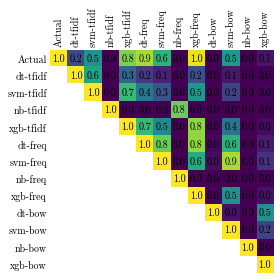

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.776331  0.496000    0.638331  0.677646
dt-freq    0.766590  0.410405    0.588506  0.718793
dt-tfidf   0.778214  0.400607    0.589892  0.592627
nb-bow     0.569187  0.418112    0.539356  0.719210
nb-freq    0.408060  0.435548    0.535017  0.712705
nb-tfidf   0.414023  0.434783    0.534710  0.583184
svm-bow    0.807139  0.523471    0.665447  0.722769
svm-freq   0.801838  0.506438    0.654213  0.687760
svm-tfidf  0.816742  0.517857    0.667471  0.521648
xgb-bow    0.794842  0.523161    0.660272  0.519788
xgb-freq   0.799772  0.489083    0.644428  0.533405
xgb-tfidf  0.799772  0.483871    0.641844  0.536116
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.656347  0.433795    0.566115  0.578896

Mean: 0.6375430728402406



Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


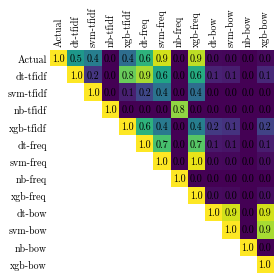

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.776665  0.489906    0.634993  0.704966
dt-freq    0.768524  0.423462    0.596059  0.502672
dt-tfidf   0.762234  0.412518    0.587496  0.708982
nb-bow     0.650586  0.487361    0.608270  0.728689
nb-freq    0.437294  0.444625    0.548407  0.632564
nb-tfidf   0.425849  0.437956    0.539602  0.721236
svm-bow    0.804720  0.555705    0.682214  0.676300
svm-freq   0.805714  0.507246    0.656483  0.709767
svm-tfidf  0.813100  0.505232    0.659404  0.665549
xgb-bow    0.794585  0.529015    0.663481  0.540343
xgb-freq   0.793596  0.477569    0.635588  0.436429
xgb-tfidf  0.782659  0.470423    0.626822  0.686454
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.662733  0.441617    0.572217  0.593381

Mean: 0.6436454771047061



Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


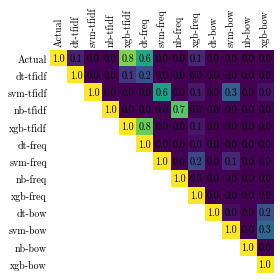

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.715631  0.465171    0.602357  0.498598
dt-freq    0.779603  0.423704    0.601751  0.519180
dt-tfidf   0.786392  0.408037    0.598216  0.656125
nb-bow     0.560115  0.418649    0.538241  0.672359
nb-freq    0.394247  0.430843    0.527925  0.672359
nb-tfidf   0.401681  0.430400    0.528215  0.499180
svm-bow    0.765207  0.515075    0.646463  0.515700
svm-freq   0.783125  0.517834    0.653217  0.686837
svm-tfidf  0.775315  0.513619    0.648324  0.522401
xgb-bow    0.745219  0.495726    0.629259  0.701028
xgb-freq   0.778751  0.478680    0.629582  0.706914
xgb-tfidf  0.800910  0.486804    0.643879  0.686837
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.637400  0.429580    0.557495  0.564425

Mean: 0.6289231646313348



Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


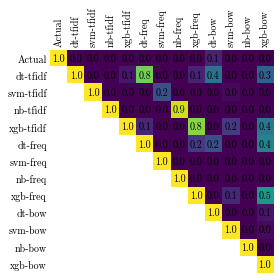

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.795975  0.439324    0.618502  0.564767
dt-freq    0.794490  0.403200    0.601319  0.576878
dt-tfidf   0.793809  0.408875    0.603356  0.750780
nb-bow     0.751065  0.486826    0.625118  0.733327
nb-freq    0.494894  0.449015    0.558244  0.731474
nb-tfidf   0.497255  0.449785    0.559266  0.553802
svm-bow    0.855473  0.512545    0.699172  0.586424
svm-freq   0.849847  0.390041    0.663461  0.679188
svm-tfidf  0.853002  0.440945    0.678808  0.763093
xgb-bow    0.826419  0.476974    0.656395  0.694262
xgb-freq   0.819068  0.437710    0.634739  0.742261
xgb-tfidf  0.817936  0.427844    0.629922  0.712110
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.703787  0.409468    0.579100  0.622182

Mean: 0.6505287941012126



Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


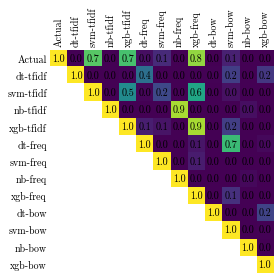

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.707559  0.428571    0.576753  0.532417
dt-freq    0.745444  0.414073    0.581067  0.551376
dt-tfidf   0.748064  0.444152    0.598834  0.717119
nb-bow     0.484026  0.456229    0.565151  0.682892
nb-freq    0.446115  0.466613    0.575539  0.709956
nb-tfidf   0.451291  0.468119    0.577560  0.547020
svm-bow    0.804208  0.540466    0.673379  0.672549
svm-freq   0.804469  0.461538    0.633937  0.632560
svm-tfidf  0.809091  0.505882    0.657528  0.718807
xgb-bow    0.774468  0.533333    0.660274  0.559130
xgb-freq   0.796795  0.487734    0.642280  0.458191
xgb-tfidf  0.791738  0.479197    0.635516  0.705722
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.643328  0.437378    0.567524  0.575980

Mean: 0.6389530605839598




Overall scores:
Friedman Chi Square Statistic: 13.14285714285711. p-value: 0.022076194515851272.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
dt-bow        0.

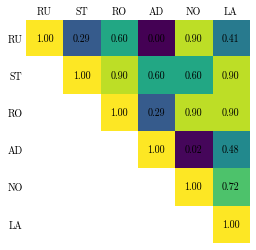

In [14]:
task_eval('binary')



Task: 5Type


Recall


Method: RandomUnder

Task: 5type.
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


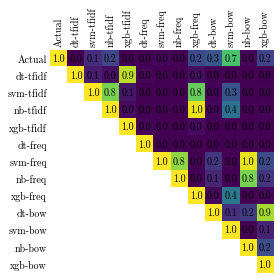

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
xgb-tfidf  0.456621  0.229412  0.375000  0.309524  0.233871    0.320886   
dt-freq    0.514840  0.300000  0.250000  0.285714  0.193548    0.308821   
dt-tfidf   0.448630  0.252941  0.250000  0.285714  0.250000    0.297457   
xgb-freq   0.391553  0.217647  0.125000  0.333333  0.298387    0.273184   
dt-bow     0.337900  0.200000  0.125000  0.500000  0.201613    0.272902   
svm-tfidf  0.402968  0.311765  0.125000  0.333333  0.145161    0.263645   
nb-freq    0.255708  0.411765  0.000000  0.428571  0.217742    0.262757   
nb-tfidf   0.381279  0.317647  0.125000  0.166667  0.298387    0.257796   
svm-bow    0.372146  0.294118  0.000000  0.452381  0.137097    0.251148   
svm-freq   0.271689  0.364706  0.125000  0.166667  0.290323    0.243677   
xgb-bow    0.334475  0.247059  0.000000  0.452381  0.153226    0.237428   
nb-bow     0.318493  0.19

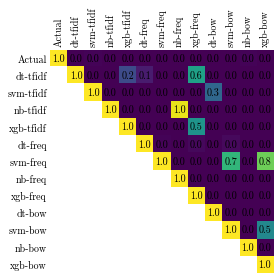

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-freq   0.563927  0.464706  0.000000  0.357143  0.185484    0.314252   
xgb-freq   0.734018  0.358824  0.000000  0.190476  0.185484    0.293760   
xgb-bow    0.561644  0.441176  0.000000  0.214286  0.225806    0.288582   
svm-tfidf  0.426941  0.405882  0.000000  0.333333  0.233871    0.280005   
svm-bow    0.585616  0.429412  0.000000  0.142857  0.241935    0.279964   
xgb-tfidf  0.763699  0.335294  0.000000  0.095238  0.169355    0.272717   
dt-bow     0.449772  0.452941  0.000000  0.214286  0.241935    0.271787   
nb-tfidf   0.139269  0.305882  0.250000  0.380952  0.201613    0.255543   
nb-freq    0.146119  0.276471  0.250000  0.380952  0.201613    0.251031   
nb-bow     0.308219  0.317647  0.125000  0.357143  0.129032    0.247408   
dt-freq    0.696347  0.264706  0.000000  0.142857  0.129032    0.246588   
dt-tfidf   0.748858  0.25

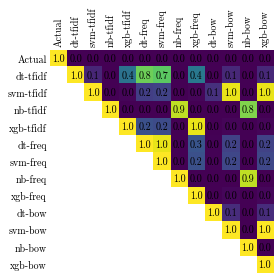

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
xgb-bow    0.628995  0.370588  0.375000  0.333333  0.137097    0.369003   
svm-tfidf  0.613014  0.382353  0.000000  0.523810  0.185484    0.340932   
svm-freq   0.641553  0.494118  0.000000  0.404762  0.129032    0.333893   
svm-bow    0.632420  0.388235  0.250000  0.238095  0.129032    0.327557   
dt-bow     0.590183  0.352941  0.250000  0.238095  0.169355    0.320115   
nb-bow     0.107306  0.270588  0.375000  0.547619  0.233871    0.306877   
xgb-tfidf  0.708904  0.341176  0.000000  0.119048  0.201613    0.274148   
xgb-freq   0.711187  0.311765  0.000000  0.119048  0.217742    0.271948   
nb-tfidf   0.116438  0.329412  0.250000  0.428571  0.185484    0.261981   
nb-freq    0.116438  0.311765  0.250000  0.452381  0.177419    0.261601   
dt-freq    0.684932  0.305882  0.000000  0.095238  0.193548    0.255920   
dt-tfidf   0.697489  0.30

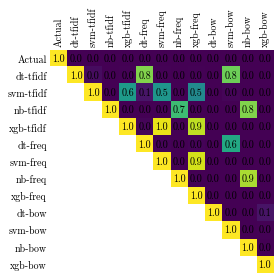

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
nb-bow     0.089041  0.311765  0.125000  0.785714  0.266129    0.315530   
svm-tfidf  0.900685  0.158824  0.250000  0.000000  0.048387    0.271579   
svm-freq   0.923516  0.170588  0.250000  0.000000  0.000000    0.268821   
nb-tfidf   0.117580  0.347059  0.250000  0.404762  0.185484    0.260977   
nb-freq    0.115297  0.294118  0.250000  0.428571  0.185484    0.254694   
xgb-freq   0.899543  0.264706  0.000000  0.000000  0.072581    0.247366   
xgb-tfidf  0.894977  0.276471  0.000000  0.000000  0.064516    0.247193   
dt-freq    0.821918  0.247059  0.000000  0.023810  0.104839    0.239525   
dt-tfidf   0.818493  0.229412  0.000000  0.023810  0.104839    0.235311   
svm-bow    0.803653  0.335294  0.000000  0.000000  0.016129    0.231015   
xgb-bow    0.730594  0.294118  0.000000  0.047619  0.032258    0.220918   
dt-bow     0.674658  0.26

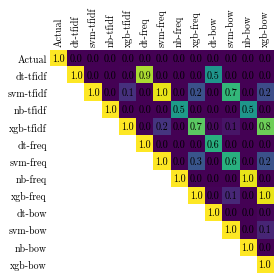

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
nb-bow     0.090183  0.305882  0.375000  0.547619  0.241935    0.312124   
dt-bow     0.816210  0.394118  0.000000  0.142857  0.072581    0.285153   
svm-bow    0.942922  0.435294  0.000000  0.000000  0.008065    0.277256   
xgb-bow    0.898402  0.388235  0.000000  0.047619  0.040323    0.274916   
xgb-freq   0.910959  0.300000  0.000000  0.000000  0.096774    0.261547   
svm-tfidf  0.948630  0.317647  0.000000  0.000000  0.040323    0.261320   
nb-tfidf   0.118721  0.352941  0.250000  0.404762  0.161290    0.257543   
xgb-tfidf  0.905251  0.282353  0.000000  0.000000  0.096774    0.256876   
dt-freq    0.825342  0.276471  0.000000  0.023810  0.112903    0.247705   
dt-tfidf   0.819635  0.288235  0.000000  0.023810  0.104839    0.247304   
nb-freq    0.115297  0.270588  0.250000  0.428571  0.169355    0.246762   
svm-freq   0.962329  0.27

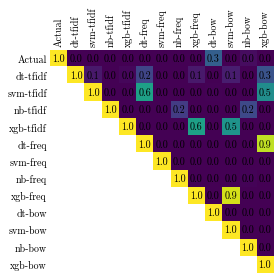

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
dt-freq    0.460046  0.370588  0.500000  0.404762  0.274194    0.401918   
dt-bow     0.367580  0.341176  0.500000  0.452381  0.298387    0.391905   
xgb-freq   0.536530  0.405882  0.250000  0.404762  0.314516    0.382338   
svm-bow    0.512557  0.500000  0.125000  0.333333  0.370968    0.368372   
dt-tfidf   0.500000  0.364706  0.375000  0.309524  0.290323    0.367910   
nb-bow     0.262557  0.370588  0.375000  0.357143  0.411290    0.355316   
xgb-tfidf  0.567352  0.317647  0.125000  0.404762  0.338710    0.350694   
svm-freq   0.644977  0.400000  0.000000  0.309524  0.314516    0.333803   
xgb-bow    0.456621  0.382353  0.125000  0.357143  0.346774    0.333578   
svm-tfidf  0.460046  0.288235  0.125000  0.452381  0.282258    0.321584   
nb-tfidf   0.251142  0.370588  0.125000  0.452381  0.233871    0.286596   
nb-freq    0.231735  0.31

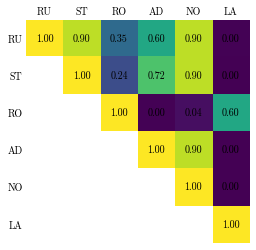

Precision


Method: RandomUnder

Task: 5type.
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


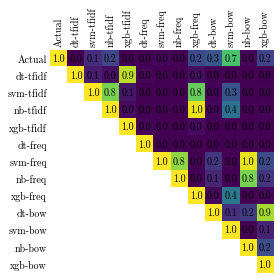

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
xgb-tfidf  0.800000  0.276596  0.014563  0.052846  0.228346    0.274470   
xgb-freq   0.797674  0.280303  0.004219  0.066351  0.176190    0.264948   
dt-freq    0.788462  0.272727  0.013333  0.080000  0.149068    0.260718   
dt-tfidf   0.797160  0.234973  0.014493  0.053097  0.172222    0.254389   
nb-tfidf   0.816626  0.237885  0.005952  0.035354  0.169725    0.253108   
svm-bow    0.827411  0.224215  0.000000  0.089202  0.096045    0.247375   
svm-tfidf  0.774123  0.223629  0.005650  0.058091  0.165138    0.245326   
dt-bow     0.806540  0.193182  0.004255  0.100000  0.107759    0.242347   
xgb-bow    0.813889  0.217617  0.000000  0.087963  0.077551    0.239404   
nb-freq    0.775087  0.212121  0.000000  0.080000  0.125000    0.238442   
nb-bow     0.820588  0.201220  0.000000  0.075000  0.079848    0.235331   
svm-freq   0.765273  0.20

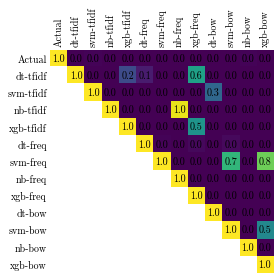

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-tfidf  0.799145  0.442308  0.000000  0.036554  0.197279    0.295057   
xgb-bow    0.780952  0.340909  0.000000  0.126761  0.166667    0.283058   
svm-freq   0.800648  0.385366  0.000000  0.066372  0.160839    0.282645   
svm-bow    0.772590  0.345972  0.000000  0.100000  0.191083    0.281929   
xgb-freq   0.799751  0.342697  0.000000  0.086957  0.170370    0.279955   
xgb-tfidf  0.793594  0.351852  0.000000  0.056338  0.160305    0.272418   
dt-bow     0.783300  0.299611  0.000000  0.078261  0.149254    0.262085   
nb-tfidf   0.813333  0.248804  0.004556  0.080402  0.112108    0.251841   
nb-freq    0.795031  0.256831  0.004535  0.079602  0.106838    0.248567   
dt-tfidf   0.769953  0.263473  0.000000  0.037500  0.166667    0.247519   
dt-freq    0.774112  0.238095  0.000000  0.056604  0.128000    0.239362   
nb-bow     0.727763  0.24

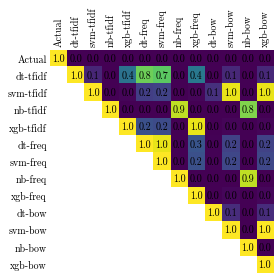

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-tfidf  0.835148  0.445205  0.000000  0.091286  0.221154    0.318559   
svm-freq   0.820438  0.432990  0.000000  0.108280  0.140351    0.300412   
xgb-bow    0.809104  0.301435  0.032609  0.128440  0.131783    0.280674   
xgb-tfidf  0.791083  0.327684  0.000000  0.076923  0.173611    0.273860   
svm-bow    0.807580  0.328358  0.022989  0.096154  0.112676    0.273551   
xgb-freq   0.791614  0.297753  0.000000  0.080645  0.186207    0.271244   
dt-bow     0.805296  0.309278  0.020408  0.083333  0.126506    0.268964   
nb-bow     0.839286  0.269006  0.008086  0.074919  0.111969    0.260653   
dt-freq    0.781250  0.254902  0.000000  0.068966  0.171429    0.255309   
dt-tfidf   0.781330  0.289773  0.000000  0.062500  0.142857    0.255292   
nb-freq    0.796875  0.256039  0.004505  0.086364  0.099548    0.248666   
nb-tfidf   0.778626  0.25

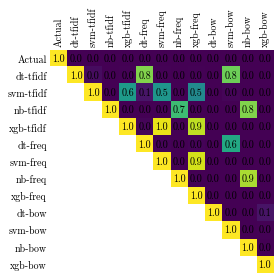

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000       1.0  1.000000    1.000000   
svm-bow    0.760259  0.483051  0.000000      None  0.500000    0.435828   
svm-tfidf  0.775811  0.385714  0.018182      None  0.260870    0.360144   
svm-freq   0.772684  0.453125  0.019802      None  0.000000    0.311403   
xgb-bow    0.760095  0.384615  0.000000  0.222222  0.088889    0.291164   
xgb-freq   0.773307  0.405405  0.000000       0.0  0.140625    0.263868   
nb-bow     0.876404  0.237668  0.005291  0.071584  0.127907    0.263771   
xgb-tfidf  0.772414  0.405172  0.000000       0.0  0.126984    0.260914   
dt-bow     0.752866  0.326087  0.000000   0.09375  0.115942    0.257729   
dt-freq    0.766773  0.293706  0.000000  0.034483  0.152941    0.249581   
nb-tfidf   0.786260  0.266968  0.004556  0.077982  0.109005    0.248954   
dt-tfidf   0.761146  0.288889  0.000000  0.029412  0.142857    0.244461   
nb-freq    0.782946  0.24

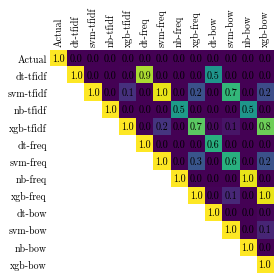

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000       1.0       1.0  1.000000    1.000000   
svm-bow    0.783681  0.453988      None      None  0.333333    0.523667   
svm-tfidf  0.770872  0.446281      None      None  0.238095    0.485083   
svm-freq   0.757412  0.464646      None      None  0.000000    0.407353   
xgb-tfidf  0.772152  0.413793      None       0.0  0.181818    0.341941   
xgb-bow    0.787000  0.392857       0.0  0.285714  0.113636    0.315842   
xgb-freq   0.773256  0.435897       0.0       0.0  0.203390    0.282509   
dt-bow     0.783991  0.364130       0.0  0.139535  0.120000    0.281531   
nb-bow     0.877778  0.238532  0.008086  0.074919  0.128205    0.265504   
dt-freq    0.768332  0.317568       0.0  0.030303  0.152174    0.253675   
dt-tfidf   0.766275  0.320261       0.0   0.03125  0.142857    0.252129   
nb-tfidf   0.787879  0.270270  0.004505  0.077982  0.098039    0.247735   
nb-freq    0.782946  0.23

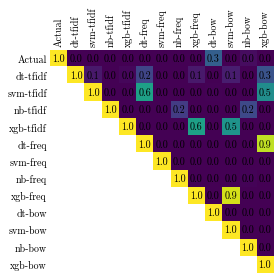

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-bow    0.837687  0.304659  0.055556  0.155556  0.154882    0.301668   
svm-freq   0.801418  0.311927  0.000000  0.164557  0.183099    0.292200   
xgb-freq   0.802048  0.273810  0.033333  0.146552  0.189320    0.289013   
xgb-tfidf  0.808130  0.257143  0.023256  0.134921  0.185841    0.281858   
xgb-bow    0.829876  0.210356  0.016949  0.145631  0.161049    0.272772   
dt-freq    0.809237  0.226619  0.053333  0.126866  0.144681    0.272147   
svm-tfidf  0.787109  0.270718  0.034483  0.057402  0.209581    0.271859   
dt-tfidf   0.780749  0.255144  0.066667  0.093525  0.155172    0.270251   
nb-bow     0.798611  0.217993  0.013514  0.109489  0.179577    0.263837   
dt-bow     0.805000  0.192691  0.041237  0.121795  0.139098    0.259964   
nb-tfidf   0.753425  0.211409  0.004000  0.102703  0.148718    0.244051   
nb-freq    0.727599  0.19

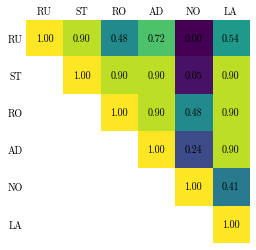



Task: F1


Task: 5type.
Cochran's Q test p-value: 2.115279943121911e-43
Post-hoc Dunn test array:


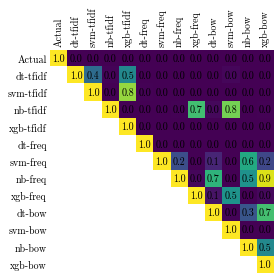

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.476267  0.196532  0.008230  0.166667  0.140449    0.256719   
dt-freq    0.622928  0.285714  0.025316  0.125000  0.168421    0.282738   
dt-tfidf   0.574142  0.243626  0.027397  0.089552  0.203947    0.274242   
nb-bow     0.458882  0.197605       NaN  0.118812  0.108527    0.212397   
nb-freq    0.384549  0.280000       NaN  0.134831  0.158824    0.250010   
nb-tfidf   0.519844  0.272040  0.011364  0.058333  0.216374    0.255431   
svm-bow    0.513386  0.254453       NaN  0.149020  0.112957    0.249247   
svm-freq   0.401011  0.260504  0.022727  0.047945  0.181360    0.235605   
svm-tfidf  0.530030  0.260442  0.010811  0.098940  0.154506    0.254156   
xgb-bow    0.474110  0.231405       NaN  0.147287  0.102981    0.238412   
xgb-freq   0.525268  0.245033  0.008163  0.110672  0.221557    0.269003   
xgb-tfidf  0.581395  0.250804  0.028037  0.090278  0.231076    0.295869   
Actual     1.000000  1.00

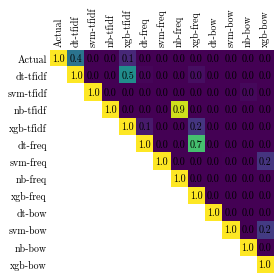

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.571429  0.360656       NaN  0.114650  0.184615    0.266848   
dt-freq    0.733173  0.250696       NaN  0.081081  0.128514    0.242922   
dt-tfidf   0.759259  0.261128       NaN  0.049180  0.155172    0.246179   
nb-bow     0.433039  0.276215  0.010152  0.102041  0.102894    0.235396   
nb-freq    0.246866  0.266289  0.008909  0.131687  0.139665    0.249793   
nb-tfidf   0.237817  0.274406  0.008949  0.132780  0.144092    0.253678   
svm-bow    0.666234  0.383202       NaN  0.117647  0.213523    0.280943   
svm-freq   0.661755  0.421333       NaN  0.111940  0.172285    0.297612   
svm-tfidf  0.556548  0.423313       NaN  0.065882  0.214022    0.287334   
xgb-bow    0.653386  0.384615       NaN  0.159292  0.191781    0.285793   
xgb-freq   0.765476  0.350575       NaN  0.119403  0.177606    0.286692   
xgb-tfidf  0.778360  0.343373       NaN  0.070796  0.164706    0.272567   
Actual     1.000000  1.00

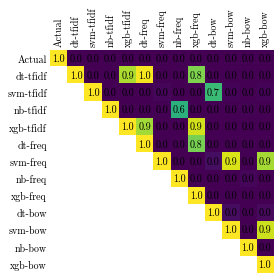

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.681159  0.329670  0.037736  0.123457  0.144828    0.292319   
dt-freq    0.729927  0.278075       NaN  0.080000  0.181818    0.255614   
dt-tfidf   0.737033  0.294798       NaN  0.075472  0.154982    0.253846   
nb-bow     0.190283  0.269795  0.015831  0.131805  0.151436    0.281883   
nb-freq    0.203187  0.281167  0.008850  0.145038  0.127536    0.254969   
nb-tfidf   0.202582  0.288660  0.008850  0.137405  0.138973    0.254052   
svm-bow    0.709347  0.355795  0.042105  0.136986  0.120301    0.298128   
svm-freq   0.720051  0.461538       NaN  0.170854  0.134454    0.316269   
svm-tfidf  0.707044  0.411392       NaN  0.155477  0.201754    0.329366   
xgb-bow    0.707771  0.332454  0.060000  0.185430  0.134387    0.318834   
xgb-freq   0.749248  0.304598       NaN  0.096154  0.200743    0.271596   
xgb-tfidf  0.747742  0.334294       NaN  0.093458  0.186567    0.274004   
Actual     1.000000  1.00

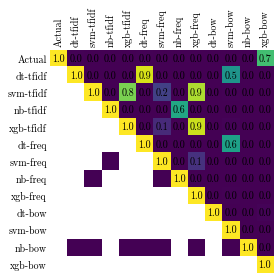

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.711620  0.292208       NaN  0.081081  0.082902    0.234470   
dt-freq    0.793388  0.268371       NaN  0.028169  0.124402    0.244449   
dt-tfidf   0.788779  0.255738       NaN  0.026316  0.120930    0.239798   
nb-bow     0.161658  0.269720  0.010152  0.131213  0.172775    0.287338   
nb-freq    0.200995  0.268817  0.008949  0.136882  0.130312    0.248910   
nb-tfidf   0.204568  0.301790  0.008949  0.130769  0.137313    0.254824   
svm-bow    0.781354  0.395833       NaN       NaN  0.031250    0.301969   
svm-freq   0.841394  0.247863  0.036697       NaN       NaN    0.288549   
svm-tfidf  0.833597  0.225000  0.033898       NaN  0.081633    0.309653   
xgb-bow    0.745052  0.333333       NaN  0.078431  0.047337    0.251223   
xgb-freq   0.831662  0.320285       NaN       NaN  0.095745    0.255350   
xgb-tfidf  0.829191  0.328671       NaN       NaN  0.085561    0.253868   
Actual     1.000000  1.00

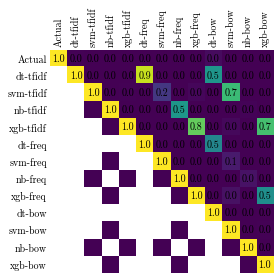

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.799776  0.378531       NaN  0.141176  0.090452    0.283331   
dt-freq    0.795817  0.295597       NaN  0.026667  0.129630    0.250655   
dt-tfidf   0.792057  0.303406       NaN  0.027027  0.120930    0.249693   
nb-bow     0.163561  0.268041  0.015831  0.131805  0.167598    0.286933   
nb-freq    0.200995  0.250000   0.00885  0.137405  0.118980    0.242643   
nb-tfidf   0.206349  0.306122   0.00885  0.130769  0.121951    0.252544   
svm-bow    0.855959  0.444444       NaN       NaN  0.015748    0.362557   
svm-freq   0.847662  0.342007       NaN       NaN       NaN    0.307206   
svm-tfidf  0.850563  0.371134       NaN       NaN  0.068966    0.339661   
xgb-bow    0.839019  0.390533       NaN  0.081633  0.059524    0.293961   
xgb-freq   0.836478  0.355401       NaN       NaN  0.131148    0.271624   
xgb-tfidf  0.833421  0.335664       NaN       NaN  0.126316    0.293366   
Actual     1.000000  1.00

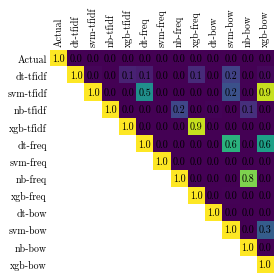

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.504702  0.246285  0.076190  0.191919  0.189744    0.312582   
dt-freq    0.586608  0.281250  0.096386  0.193182  0.189415    0.324541   
dt-tfidf   0.609603  0.300242  0.113208  0.143646  0.202247    0.311608   
nb-bow     0.395189  0.274510  0.026087  0.167598  0.250000    0.302818   
nb-freq    0.351515  0.237136  0.014925  0.132075  0.150838    0.244930   
nb-tfidf   0.376712  0.269231  0.007752  0.167401  0.181818    0.263618   
svm-bow    0.635977  0.378619  0.076923  0.212121  0.218527    0.331700   
svm-freq   0.714738  0.350515       NaN  0.214876  0.231454    0.311619   
svm-tfidf  0.580692  0.279202  0.054054  0.101877  0.240550    0.294638   
xgb-bow    0.589102  0.271399  0.029851  0.206897  0.219949    0.300126   
xgb-freq   0.642955  0.327014  0.058824  0.215190  0.236364    0.329189   
xgb-tfidf  0.666667  0.284211  0.039216  0.202381  0.240000    0.312531   
Actual     1.000000  1.00

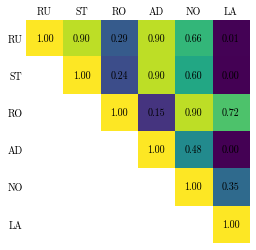

In [15]:
task_eval('5type')



Task: 4Type


Recall


Method: RandomUnder

Task: 4type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


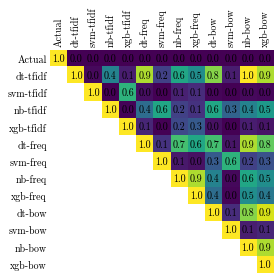

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.300000  0.875000  0.333333  0.146341    0.413669  0.352941
dt-tfidf   0.411765  0.500000  0.410256  0.227642    0.387416  0.326471
svm-bow    0.523529  0.125000  0.538462  0.243902    0.357723  0.347059
nb-tfidf   0.423529  0.125000  0.615385  0.252033    0.353987  0.397059
xgb-bow    0.435294  0.125000  0.641026  0.162602    0.340980  0.341176
xgb-freq   0.329412  0.250000  0.487179  0.260163    0.331688  0.347059
xgb-tfidf  0.341176  0.500000  0.307692  0.170732    0.329900  0.414706
dt-bow     0.470588  0.125000  0.564103  0.146341    0.326508  0.376471
svm-freq   0.470588  0.000000  0.564103  0.268293    0.325746  0.261765
dt-freq    0.435294  0.250000  0.410256  0.195122    0.322668  0.279412
nb-bow     0.388235  0.000000  0.512821  0.260163    0.290305  0.355882
nb-freq    0.394118  0.250000  0.256410  0.260163    0.290173  0

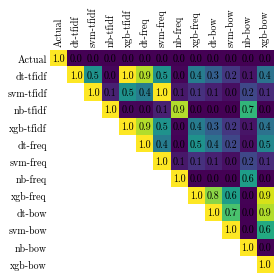

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
svm-bow    0.600000  0.250000  0.435897  0.398374    0.421068  0.444118
nb-bow     0.494118  0.500000  0.564103  0.121951    0.420043  0.367647
dt-bow     0.582353  0.125000  0.538462  0.357724    0.400885  0.417647
svm-tfidf  0.482353  0.000000  0.820513  0.227642    0.382627  0.479412
xgb-bow    0.552941  0.125000  0.435897  0.414634    0.382118  0.344118
xgb-freq   0.570588  0.000000  0.538462  0.357724    0.366693  0.450000
svm-freq   0.529412  0.000000  0.666667  0.211382    0.351865  0.485294
dt-tfidf   0.570588  0.000000  0.538462  0.268293    0.344336  0.444118
dt-freq    0.576471  0.000000  0.461538  0.300813    0.334706  0.350000
xgb-tfidf  0.564706  0.000000  0.461538  0.300813    0.331764  0.417647
nb-freq    0.523529  0.375000  0.307692  0.105691    0.327978  0.500000
nb-tfidf   0.529412  0.375000  0.282051  0.121951    0.327104  0

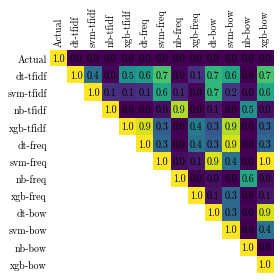

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.541176  0.250000  0.615385  0.195122    0.400421  0.458824
svm-tfidf  0.476471  0.125000  0.820513  0.178862    0.400211  0.314706
svm-freq   0.511765  0.125000  0.743590  0.211382    0.397934  0.494118
xgb-bow    0.517647  0.250000  0.564103  0.252033    0.395946  0.335294
svm-bow    0.605882  0.125000  0.589744  0.227642    0.387067  0.435294
xgb-freq   0.564706  0.000000  0.487179  0.430894    0.370695  0.341176
dt-freq    0.535294  0.000000  0.461538  0.382114    0.344737  0.420588
nb-bow     0.447059  0.500000  0.282051  0.130081    0.339798  0.420588
nb-tfidf   0.494118  0.375000  0.282051  0.146341    0.324378  0.455882
nb-freq    0.505882  0.375000  0.307692  0.105691    0.323566  0.417647
xgb-tfidf  0.570588  0.000000  0.282051  0.398374    0.312753  0.400000
dt-tfidf   0.558824  0.000000  0.307692  0.333333    0.299962  0

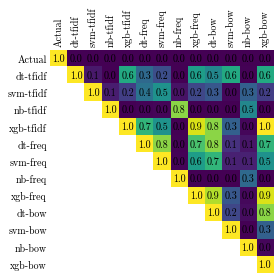

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471  0.500000  0.794872  0.113821    0.471291  0.476471
xgb-bow    0.647059  0.125000  0.256410  0.333333    0.340451  0.344118
nb-tfidf   0.529412  0.375000  0.307692  0.121951    0.333514  0.517647
dt-tfidf   0.694118  0.000000  0.307692  0.317073    0.329721  0.423529
dt-bow     0.670588  0.125000  0.230769  0.284553    0.327728  0.352941
nb-freq    0.529412  0.375000  0.307692  0.097561    0.327416  0.382353
svm-bow    0.735294  0.125000  0.025641  0.398374    0.321077  0.497059
xgb-freq   0.664706  0.000000  0.230769  0.317073    0.303137  0.458824
xgb-tfidf  0.664706  0.000000  0.205128  0.333333    0.300792  0.476471
dt-freq    0.641176  0.000000  0.230769  0.308943    0.295222  0.473529
svm-tfidf  0.558824  0.125000  0.000000  0.390244    0.268517  0.467647
svm-freq   0.652941  0.000000  0.000000  0.341463    0.248601  0

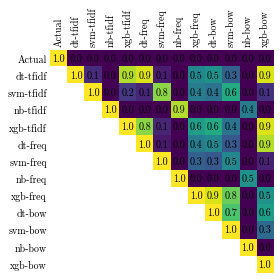

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.717647  0.125000  0.358974  0.325203    0.381706  0.500000
xgb-freq   0.700000  0.000000  0.282051  0.390244    0.343074  0.491176
nb-bow     0.458824  0.500000  0.307692  0.105691    0.343052  0.497059
xgb-bow    0.664706  0.000000  0.333333  0.349593    0.336908  0.520588
nb-tfidf   0.517647  0.375000  0.307692  0.121951    0.330573  0.314706
nb-freq    0.523529  0.375000  0.307692  0.097561    0.325946  0.535294
xgb-tfidf  0.682353  0.000000  0.230769  0.365854    0.319744  0.523529
dt-freq    0.694118  0.000000  0.256410  0.317073    0.316900  0.564706
dt-tfidf   0.688235  0.000000  0.230769  0.341463    0.315117  0.341176
svm-freq   0.829412  0.000000  0.000000  0.414634    0.311011  0.494118
svm-tfidf  0.800000  0.000000  0.000000  0.430894    0.307724  0.555882
svm-bow    0.758824  0.000000  0.025641  0.422764    0.301807  0

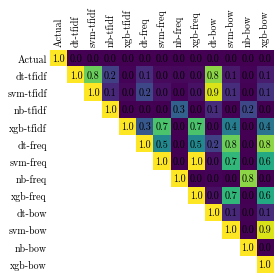

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.658824  0.500000  0.512821  0.479675    0.537830  0.479412
dt-freq    0.547059  0.500000  0.589744  0.487805    0.531152  0.373529
dt-bow     0.441176  0.500000  0.615385  0.479675    0.509059  0.476471
dt-tfidf   0.511765  0.500000  0.615385  0.357724    0.496218  0.558824
xgb-freq   0.629412  0.250000  0.487179  0.504065    0.467664  0.414706
xgb-bow    0.588235  0.250000  0.410256  0.528455    0.444237  0.529412
svm-freq   0.729412  0.000000  0.615385  0.341463    0.421565  0.467647
svm-bow    0.629412  0.125000  0.384615  0.495935    0.408741  0.573529
svm-tfidf  0.558824  0.000000  0.538462  0.382114    0.369850  0.558824
nb-tfidf   0.417647  0.125000  0.410256  0.430894    0.345949  0.541176
nb-freq    0.394118  0.125000  0.538462  0.308943    0.341631  0.364706
nb-bow     0.294118  0.125000  0.410256  0.463415    0.323197  0

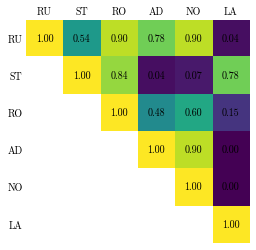

Precision


Method: RandomUnder

Task: 4type.
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


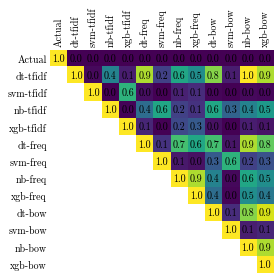

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.645161  0.009091  0.328358  0.461538    0.361037  0.320588
svm-bow    0.669173  0.014925  0.287671  0.447761    0.354883  0.397059
svm-tfidf  0.689189  0.041420  0.236364  0.428571    0.348886  0.279412
nb-bow     0.647059  0.000000  0.277778  0.421053    0.336472  0.326471
nb-tfidf   0.699029  0.019231  0.233010  0.378049    0.332330  0.261765
svm-freq   0.714286  0.000000  0.188034  0.412500    0.328705  0.347059
dt-tfidf   0.693069  0.054795  0.173913  0.378378    0.325039  0.376471
xgb-bow    0.632479  0.011905  0.304878  0.350877    0.325035  0.355882
nb-freq    0.676768  0.023810  0.138889  0.376471    0.303984  0.341176
xgb-freq   0.577320  0.033898  0.220930  0.326531    0.289670  0.347059
xgb-tfidf  0.552381  0.045455  0.123711  0.420000    0.285387  0.352941
dt-freq    0.621849  0.052632  0.155340  0.300000    0.282455  0

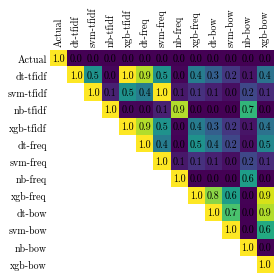

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
svm-bow    0.713287  0.074074  0.309091  0.426087    0.380635  0.450000
svm-tfidf  0.745455  0.000000  0.219178  0.518519    0.370788  0.444118
dt-bow     0.692308  0.034483  0.308824  0.440000    0.368903  0.476471
xgb-bow    0.686131  0.038462  0.303571  0.421488    0.362413  0.485294
nb-tfidf   0.750000  0.021898  0.234043  0.416667    0.355652  0.417647
xgb-freq   0.697842  0.000000  0.241379  0.453608    0.348207  0.417647
nb-freq    0.760684  0.021739  0.255319  0.342105    0.344962  0.444118
nb-bow     0.750000  0.044444  0.241758  0.319149    0.338838  0.350000
svm-freq   0.692308  0.000000  0.247619  0.376812    0.329185  0.344118
dt-tfidf   0.646667  0.000000  0.250000  0.397590    0.323564  0.479412
dt-freq    0.671233  0.000000  0.219512  0.397849    0.322149  0.367647
xgb-tfidf  0.680851  0.000000  0.206897  0.397849    0.321399  0

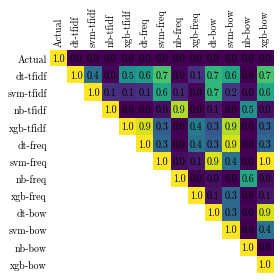

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
svm-bow    0.725352  0.016667  0.302632  0.451613    0.374066  0.458824
dt-bow     0.686567  0.025641  0.333333  0.428571    0.368528  0.494118
xgb-bow    0.666667  0.027778  0.349206  0.424658    0.367077  0.455882
nb-bow     0.817204  0.025806  0.203704  0.421053    0.366942  0.435294
nb-tfidf   0.785047  0.021277  0.220000  0.428571    0.363724  0.400000
svm-tfidf  0.750000  0.025641  0.225352  0.431373    0.358091  0.461765
xgb-freq   0.695652  0.000000  0.250000  0.473214    0.354717  0.335294
svm-freq   0.696000  0.029412  0.247863  0.406250    0.344881  0.420588
nb-freq    0.767857  0.021583  0.226415  0.361111    0.344242  0.341176
dt-freq    0.659420  0.000000  0.230769  0.431193    0.330346  0.314706
xgb-tfidf  0.683099  0.000000  0.174603  0.437500    0.323800  0.417647
dt-tfidf   0.655172  0.000000  0.181818  0.405941    0.310733  0

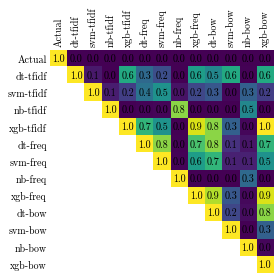

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000       1.0  1.000000    1.000000  1.000000
svm-tfidf  0.633333  0.010870      None  0.489796    0.378000  0.458824
nb-bow     0.794118  0.044944  0.274336  0.388889    0.375572  0.497059
svm-freq   0.623596  0.000000      None  0.494118    0.372571  0.344118
nb-tfidf   0.750000  0.022222      0.24  0.428571    0.360198  0.352941
svm-bow    0.637755  0.043478  0.333333  0.415254    0.357455  0.476471
nb-freq    0.756303  0.021898  0.230769  0.375000    0.345992  0.423529
dt-tfidf   0.608247  0.000000       0.3  0.464286    0.343133  0.467647
xgb-bow    0.621469  0.037037  0.322581  0.390476    0.342891  0.473529
dt-bow     0.626374  0.038462  0.236842  0.372340    0.318504  0.450000
xgb-freq   0.601064  0.000000  0.257143  0.406250    0.316114  0.517647
xgb-tfidf  0.594737  0.000000  0.235294  0.427083    0.314279  0.382353
dt-freq    0.579787  0.000000  0.243243  0.413043    0.309018  0

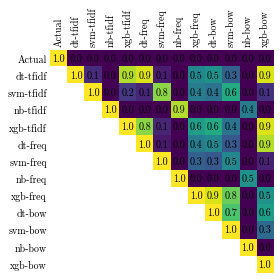

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000       1.0       1.0  1.000000    1.000000  1.000000
svm-freq   0.607759      None      None  0.472222    0.539990  0.341176
svm-bow    0.626214      None  0.333333  0.396947    0.452164  0.500000
dt-bow     0.619289      0.25  0.318182  0.421053    0.402131  0.564706
nb-tfidf   0.765217  0.021277  0.244898  0.428571    0.364991  0.555882
nb-bow     0.795918  0.025806  0.218182  0.406250    0.361539  0.494118
svm-tfidf  0.596491       0.0      None  0.481818    0.359436  0.314706
nb-freq    0.754237  0.021583  0.235294  0.375000    0.346529  0.347059
xgb-freq   0.619792       0.0  0.289474  0.452830    0.340524  0.491176
xgb-bow    0.601064       0.0  0.382353  0.370690    0.338527  0.523529
xgb-tfidf  0.597938       0.0  0.257143  0.424528    0.319902  0.535294
dt-freq    0.590000       0.0  0.277778  0.410526    0.319576  0.497059
dt-tfidf   0.600000       0.0  0.236842  0.428571    0.316353  0

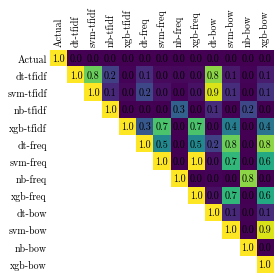

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000       1.0  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.629213  0.307692  0.555556  0.522124    0.503646  0.373529
xgb-freq   0.648485  0.181818  0.487179  0.496000    0.453371  0.414706
svm-tfidf  0.575758      None  0.283784  0.465347    0.441629  0.364706
dt-freq    0.636986  0.190476  0.365079  0.545455    0.434499  0.558824
xgb-bow    0.666667  0.105263  0.421053  0.488722    0.420426  0.479412
svm-bow    0.644578     0.125  0.441176  0.462121    0.418219  0.573529
dt-bow     0.609756  0.210526  0.369231  0.443609    0.408281  0.541176
dt-tfidf   0.621429  0.166667  0.279070  0.488889    0.389013  0.558824
svm-freq   0.642487       0.0  0.413793  0.477273    0.383388  0.529412
nb-tfidf   0.669811  0.014085  0.313725  0.473214    0.367709  0.467647
nb-bow     0.531915  0.017544  0.470588  0.367742    0.346947  0.538235
nb-freq    0.620370  0.013889  0.368421  0.368932    0.342903  0

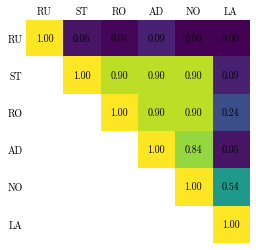



Task: F1


Task: 4type.
Cochran's Q test p-value: 6.3506353292571246e-21
Post-hoc Dunn test array:


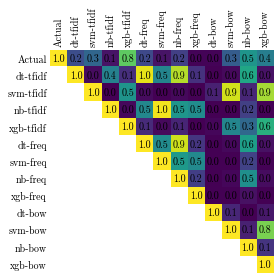

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.544218  0.016949  0.415094  0.222222    0.342906  0.346289
dt-freq    0.512111  0.086957  0.225352  0.236453    0.301225  0.333873
dt-tfidf   0.516605  0.098765  0.244275  0.284264    0.353497  0.349692
nb-bow     0.485294       NaN  0.360360  0.321608    0.311688  0.340543
nb-freq    0.498141  0.043478  0.180180  0.307692    0.296918  0.330562
nb-tfidf   0.527473  0.033333  0.338028  0.302439    0.342816  0.315520
svm-bow    0.587459  0.026667  0.375000  0.315789    0.356297  0.370379
svm-freq   0.567376       NaN  0.282051  0.325123    0.327219  0.298437
svm-tfidf  0.418033  0.079096  0.276596  0.218182    0.378526  0.311902
xgb-bow    0.515679  0.021739  0.413223  0.222222    0.332817  0.348374
xgb-freq   0.419476  0.059701  0.304000  0.289593    0.309258  0.347059
xgb-tfidf  0.421818  0.083333  0.176471  0.242775    0.306033  0.381339
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1

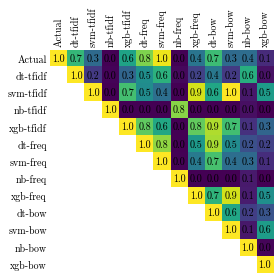

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.632588  0.054054  0.392523  0.394619    0.384230  0.445124
dt-freq    0.620253       NaN  0.297521  0.342593    0.328307  0.358607
dt-tfidf   0.606250       NaN  0.341463  0.320388    0.333627  0.461090
nb-bow     0.595745  0.081633  0.338462  0.176471    0.375096  0.358607
nb-freq    0.620209  0.041096  0.279070  0.161491    0.336256  0.470405
nb-tfidf   0.620690  0.041379  0.255814  0.188679    0.340781  0.445124
svm-bow    0.651757  0.114286  0.361702  0.411765    0.399832  0.447039
svm-freq   0.600000       NaN  0.361111  0.270833    0.340147  0.402691
svm-tfidf  0.585714       NaN  0.345946  0.316384    0.376614  0.461090
xgb-bow    0.612378  0.058824  0.357895  0.418033    0.372005  0.402691
xgb-freq   0.627832       NaN  0.333333  0.400000    0.357211  0.433220
xgb-tfidf  0.617363       NaN  0.285714  0.342593    0.326500  0.455128
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1

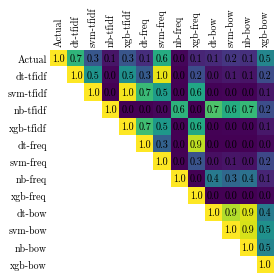

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.605263  0.046512  0.432432  0.268156    0.383813  0.475817
dt-freq    0.590909       NaN  0.307692  0.405172    0.337388  0.360024
dt-tfidf   0.603175       NaN  0.228571  0.366071    0.305253  0.440216
nb-bow     0.577947  0.049080  0.236559  0.198758    0.352849  0.427815
nb-freq    0.609929  0.040816  0.260870  0.163522    0.333584  0.375559
nb-tfidf   0.606498  0.040268  0.247191  0.218182    0.342926  0.426117
svm-bow    0.660256  0.029412  0.400000  0.302703    0.380455  0.446749
svm-freq   0.589831  0.047619  0.371795  0.278075    0.369513  0.454398
svm-tfidf  0.582734  0.042553  0.353591  0.252874    0.377982  0.374309
xgb-bow    0.582781  0.050000  0.431373  0.316327    0.380965  0.386398
xgb-freq   0.623377       NaN  0.330435  0.451064    0.362530  0.338210
xgb-tfidf  0.621795       NaN  0.215686  0.417021    0.318181  0.408633
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1

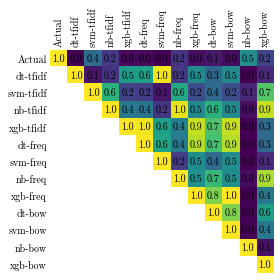

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.647727  0.058824  0.233766  0.322581    0.323050  0.395604
dt-freq    0.608939       NaN  0.236842  0.353488    0.301963  0.474995
dt-tfidf   0.648352       NaN  0.303797  0.376812    0.336293  0.444496
nb-bow     0.595588  0.082474  0.407895  0.176101    0.418022  0.486547
nb-freq    0.622837  0.041379  0.263736  0.154839    0.336448  0.401889
nb-tfidf   0.620690  0.041958  0.269663  0.189873    0.346343  0.419714
svm-bow    0.683060  0.064516  0.047619  0.406639    0.338291  0.486547
svm-freq   0.637931       NaN       NaN  0.403846    0.298216  0.390000
svm-tfidf  0.593750  0.020000       NaN  0.434389    0.313988  0.463193
xgb-bow    0.634006  0.057143  0.285714  0.359649    0.341666  0.398582
xgb-freq   0.631285       NaN  0.243243  0.356164    0.309490  0.486464
xgb-tfidf  0.627778       NaN  0.219178  0.374429    0.307387  0.424255
Actual     1.000000  1.000000       1.0  1.000000    1.000000  1

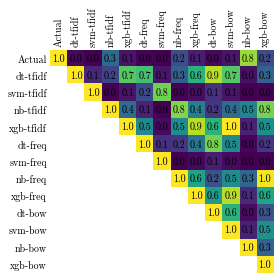

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.664850  0.166667  0.337349  0.366972    0.391652  0.530387
dt-freq    0.637838       NaN  0.266667  0.357798    0.318233  0.528727
dt-tfidf   0.641096       NaN  0.233766  0.380090    0.315734  0.412206
nb-bow     0.582090   0.04908  0.255319  0.167742    0.352053  0.495584
nb-freq    0.618056  0.040816  0.266667  0.154839    0.335922  0.421098
nb-tfidf   0.617544  0.040268  0.272727  0.189873    0.346930  0.401888
svm-bow    0.686170       NaN  0.047619  0.409449    0.361994  0.409722
svm-freq   0.701493       NaN       NaN  0.441558    0.394695  0.403645
svm-tfidf  0.683417       NaN       NaN  0.454936    0.331576  0.401888
xgb-bow    0.631285       NaN  0.356164  0.359833    0.337715  0.522055
xgb-freq   0.657459       NaN  0.285714  0.419214    0.341794  0.491176
xgb-tfidf  0.637363       NaN  0.243243  0.393013    0.319823  0.529346
Actual     1.000000       1.0       1.0  1.000000    1.000000  1

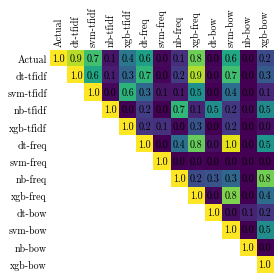

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.511945  0.296296  0.461538  0.460937    0.453134  0.506766
dt-freq    0.588608  0.275862  0.450980  0.515021    0.477988  0.447764
dt-tfidf   0.561290      0.25  0.384000  0.413146    0.436124  0.558824
nb-bow     0.378788  0.030769  0.438356  0.410072    0.334651  0.538235
nb-freq    0.482014     0.025  0.437500  0.336283    0.342266  0.413163
nb-tfidf   0.514493  0.025316  0.355556  0.451064    0.356497  0.501732
svm-bow    0.636905     0.125  0.410959  0.478431    0.413425  0.573529
svm-freq   0.683196       NaN  0.494845  0.398104    0.401571  0.496616
svm-tfidf  0.567164       NaN  0.371681  0.419643    0.402565  0.441364
xgb-bow    0.625000  0.148148  0.415584  0.507812    0.432004  0.503173
xgb-freq   0.638806  0.210526  0.487179  0.500000    0.460406  0.414706
xgb-tfidf  0.643678  0.380952  0.533333  0.500000    0.520177  0.419899
Actual     1.000000       1.0  1.000000  1.000000    1.000000  1

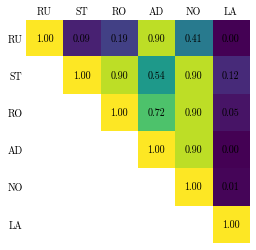

In [16]:
task_eval('4type')